### Libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

import warnings
import os

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RepeatedKFold


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
warnings.filterwarnings("ignore")
os.chdir("C:\\Users\\joaos\\Documents\\GitHub\\pred_se_ml\\data")

### Importing the data

In [4]:
# Importing the data
df = pd.read_csv("pred_se_ml.csv")

print(df.shape)

df.head()

(2820, 25)


,country,year,fdi,property_time,cost_procedures,business_time,business_procedure,tribute_time,governement_spending,exchange,inflation,gdp_pc,unemployment,democ,tax_burden,diversity,quality,se_medina,democ_closed_anocracy,democ_democracy,democ_full_democracy,democ_interregnum,democ_interruption,democ_open_anocracy,democ_transition
0,angola,1995,8.529489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1825.495149,398.120223,NaN,transition,61.6,6.002369,0.37,52.47,0,0,0,0,0,0,1
1,angola,1996,2.762770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4800.531644,454.375004,NaN,transition,54.6,6.048760,0.40,46.30,0,0,0,0,0,0,1
2,angola,1997,5.363360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.453022,516.127849,NaN,autocracy,52.6,5.991146,0.35,50.48,0,0,0,0,0,0,0
3,angola,1998,17.121191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.359348,423.403332,NaN,autocracy,59.1,5.882152,0.34,49.21,0,0,0,0,0,0,0
4,angola,1999,40.167251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,557.501113,387.689415,NaN,autocracy,47.9,5.903543,0.34,48.64,0,0,0,0,0,0,0


In [5]:
# Missing data by column (%)
df.isnull().mean().sort_values(ascending=False).head(10)

tribute_time            0.536879
property_time           0.496454
cost_procedures         0.456383
business_time           0.456383
business_procedure      0.456383
unemployment            0.351418
governement_spending    0.087589
exchange                0.067730
tax_burden              0.046454
quality                 0.012057
dtype: float64

In [6]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                2820 non-null   object 
 1   year                   2820 non-null   int64  
 2   fdi                    2802 non-null   float64
 3   property_time          1420 non-null   float64
 4   cost_procedures        1533 non-null   float64
 5   business_time          1533 non-null   float64
 6   business_procedure     1533 non-null   float64
 7   tribute_time           1306 non-null   float64
 8   governement_spending   2573 non-null   float64
 9   exchange               2629 non-null   float64
 10  inflation              2802 non-null   float64
 11  gdp_pc                 2815 non-null   float64
 12  unemployment           1829 non-null   float64
 13  democ                  2820 non-null   object 
 14  tax_burden             2689 non-null   float64
 15  dive

There is already dummy columns regarding democracy, hence, the democ column will be dropped

In [7]:
df = df.drop('democ', axis=1)

### Dealing with missing data

There is a lot of missing data, especially in relation to the tribute_time, however, if we limit the year range from 2004 to 2014, the proportion of missing data will decrease

In [8]:
df = df[(df['year']>=2004) & (df['year'] <= 2014)]

In [9]:
# Proportion of missing data by country in the column 'unemployment' since it's the variable with the biggest proportion of missing data
missing_by_country = df.groupby('country')['unemployment'].apply(lambda x: x.isnull().sum() / x.count()).sort_values(ascending=False)
#print(missing_by_country)

# Collecting the names of countries that have a proportion of missing data in the unemployment column above 5%
countries = missing_by_country[missing_by_country > 5].index.tolist()
#countries

# Removing these countries
df = df[~df['country'].isin(countries)]

In [10]:
# Replacing missing values with the average for each country for each attribute
mean_by_country = df.groupby('country').transform('mean')
df.fillna(mean_by_country, inplace=True)

After the imputation, 'government spending' and 'exchange' still having missing values, this happens because some countries have the 'inf' as observations and not a usual NaN


In [11]:
# This is seen with the follow code for governement_spending and after for exchange (just change governement_spending by exchange to see all the countries)
missing_by_country = df.groupby('country')['governement_spending'].apply(lambda x: x.isnull().sum() / x.count()).sort_values(ascending=False)
print(missing_by_country)

country
malawi                 inf
cote_d'ivoire          inf
liberia                inf
trinidad_and_tobago    inf
nigeria                inf
albania                0.0
netherlands            0.0
new_zealand            0.0
nicaragua              0.0
niger                  0.0
norway                 0.0
morocco                0.0
pakistan               0.0
paraguay               0.0
peru                   0.0
philippines            0.0
poland                 0.0
namibia                0.0
moldova                0.0
mongolia               0.0
qatar                  0.0
mexico                 0.0
mauritius              0.0
mali                   0.0
malaysia               0.0
madagascar             0.0
luxembourg             0.0
lithuania              0.0
lesotho                0.0
lebanon                0.0
latvia                 0.0
laos                   0.0
portugal               0.0
romania                0.0
kuwait                 0.0
russian_federation     0.0
zambia              

In [17]:
len(df['country'].unique())

122

In [19]:
# Droping these countries
#countries_to_drop = ['malawi', 'trinidad_and_tobago', 'liberia', "cote_d'ivoire", "nigeria"]
#df = df[~df['country'].isin(countries_to_drop)]

In [20]:
# No more missing values
df.isnull().mean().sort_values(ascending=False).head(10)

country                  0.0
year                     0.0
democ_open_anocracy      0.0
democ_interruption       0.0
democ_interregnum        0.0
democ_full_democracy     0.0
democ_democracy          0.0
democ_closed_anocracy    0.0
se_medina                0.0
quality                  0.0
dtype: float64

In [22]:
# Droping columns that will not be used
df = df.drop(['country', 'year'], axis=1)

In [23]:
df.describe()

,fdi,property_time,cost_procedures,business_time,business_procedure,tribute_time,governement_spending,exchange,inflation,gdp_pc,unemployment,tax_burden,diversity,quality,se_medina,democ_closed_anocracy,democ_democracy,democ_full_democracy,democ_interregnum,democ_interruption,democ_open_anocracy,democ_transition
count,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000
mean,5.644653,58.314274,48.977654,36.905042,8.799962,300.163634,15.500761,85.635514,6.874259,14834.173296,7.606760,74.814428,3.191293,0.832254,28.650225,0.095417,0.341848,0.273479,0.004508,0.000751,0.144252,0.007513
std,14.971666,70.670154,120.737435,61.625117,3.504920,285.159095,5.183879,49.045314,8.832999,20727.072247,5.202705,12.822870,1.186212,0.160781,12.956233,0.293900,0.474507,0.445912,0.067014,0.027410,0.351478,0.086385
min,-57.532314,1.000000,0.000000,0.500000,1.000000,27.000000,2.047121,22.105976,-24.218101,128.538423,0.200000,32.000000,1.422673,0.240000,6.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.401812,18.500000,4.533333,12.000000,6.000000,172.500000,11.611602,54.795774,1.943442,1529.024412,4.051500,67.428750,2.169870,0.760000,18.705000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.064761,36.000000,14.700000,22.000000,9.000000,248.000000,15.036616,75.377816,4.690469,5259.931753,6.491000,77.000000,2.976245,0.860000,28.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.979808,67.500000,43.700000,41.000000,11.000000,329.000000,18.815722,104.095025,9.358437,19273.177116,9.838000,83.389550,4.030939,0.960000,37.045000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,280.145510,690.000000,1491.600000,697.000000,20.000000,2600.000000,43.482316,437.326715,95.408660,123678.702143,35.460000,99.942400,6.330621,1.100000,69.080000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# Renaming the columns for better future visualization
rename_dictionary = {'se_medina':'Shadow Economy',
                        'lgdp_pc': 'Log. GDP Per Capita', 
                         'democ_transition': 'Dem. Transition', 
                         'democ_interruption': 'Dem. Interruption',
                        'democ_interregnum':'Dem. Interregnum',
                        'democ_full_democracy': 'Dem. Full',
                        'democ_democracy':'Democracy',
                        'democ_autocracy':'Autocracy',
                        'democ_closed_anocracy':'Closed Anocracy',
                        'democ_open_anocracy': 'Open Anocracy',
                        'quality':'Quality',
                        'diversity':'Diversity',
                        'tax_burden':'Tax Burden',
                        'unemployment':'Unemployment',
                        'inflation':'Inflation',
                        'exchange':'Exchange',
                        'governement_spending':'Government Spending',
                         'tribute_time':'Tribute Time',
                        'business_procedure':'Business Procedure',
                        'business_time':'Business Time',
                        'cost_procedures':'Cost Procedures',
                        'property_time':'Property Time',
                        'fdi':'FDI'}

df = df.rename(columns=rename_dictionary)

In [25]:
# Changing the order
new_order = ['Shadow Economy', 'FDI', 'Property Time', 'Cost Procedures', 'Business Time', 'Business Procedure',
               'Tribute Time', 'Government Spending', 'Exchange', 'Inflation', 'Unemployment', 'Tax Burden', 
               'Diversity', 'Quality', 'Closed Anocracy', 'Democracy', 'Dem. Full', 'Dem. Interregnum', 
               'Dem. Interruption', 'Open Anocracy', 'Dem. Transition', 'Log. GDP Per Capita']

df = df.reindex(columns=new_order)

In [26]:
df.head()

,Shadow Economy,FDI,Property Time,Cost Procedures,Business Time,Business Procedure,Tribute Time,Government Spending,Exchange,Inflation,Unemployment,Tax Burden,Diversity,Quality,Closed Anocracy,Democracy,Dem. Full,Dem. Interregnum,Dem. Interruption,Open Anocracy,Dem. Transition,Log. GDP Per Capita
9,46.81,9.329239,335.0,910.0,83.0,12.0,289.0,14.312063,103.579947,33.443595,23.6430,84.916689,6.330621,0.40,1,0,0,0,0,0,0,NaN
10,43.84,-3.526657,335.0,653.8,83.0,12.0,284.0,16.029037,106.590962,42.374249,12.6408,84.916689,6.245515,0.42,1,0,0,0,0,0,0,NaN
11,41.23,-0.072001,335.0,498.2,83.0,12.0,284.0,15.341722,94.625159,17.115665,12.6408,84.900000,6.295336,0.40,1,0,0,0,0,0,0,NaN
12,37.13,-1.368762,335.0,343.7,83.0,12.0,284.0,15.536935,108.060068,4.308432,12.6408,85.000000,6.211946,0.45,1,0,0,0,0,0,0,NaN
13,35.26,1.896314,335.0,196.8,68.0,8.0,284.0,16.814612,121.364708,19.365774,12.6408,85.175100,6.315526,0.47,1,0,0,0,0,0,0,NaN


In [110]:
df.describe()

,Shadow Economy,FDI,Property Time,Cost Procedures,Business Time,Business Procedure,Tribute Time,Government Spending,Exchange,Inflation,Unemployment,Tax Burden,Diversity,Quality,Closed Anocracy,Democracy,Dem. Full,Dem. Interregnum,Dem. Interruption,Open Anocracy,Dem. Transition,Log. GDP Per Capita
count,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000
mean,28.629143,5.608636,57.992026,49.665989,36.920351,8.795641,299.736063,15.483090,85.492668,6.916863,7.671661,74.877237,3.209882,0.829560,0.100596,0.339046,0.271237,0.005216,0.000745,0.144560,0.007452,8.588157
std,12.909337,14.917315,70.468986,120.674253,61.403443,3.500245,284.026103,5.167257,48.878491,8.842578,5.231127,12.798732,1.199360,0.162859,0.300905,0.473562,0.444764,0.072061,0.027298,0.351788,0.086032,1.540466
min,6.160000,-57.532314,1.000000,0.000000,0.500000,1.000000,27.000000,2.047121,22.105976,-24.218101,0.200000,32.000000,1.422673,0.240000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.856228
25%,18.802500,1.351173,19.000000,4.600000,12.000000,6.000000,173.000000,11.646216,54.838832,1.954999,4.080750,67.494300,2.176529,0.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.307145
50%,28.880000,3.047118,35.750000,14.900000,22.000000,9.000000,248.000000,15.024486,75.181356,4.734237,6.549000,77.072200,2.985058,0.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.551630
75%,37.007500,5.908092,67.000000,44.650000,41.375000,11.000000,328.000000,18.776336,103.560844,9.391646,9.910000,83.379100,4.086913,0.960000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.853675
max,69.080000,280.145510,690.000000,1491.600000,697.000000,20.000000,2600.000000,43.482316,437.326715,95.408660,35.460000,99.942400,6.330621,1.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.725442


In [63]:
# Exporting
# df.to_excel('df.xlsx', index=False)

### Spliting between train and test

In [105]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)

In [106]:
print(train_set.shape)
print(test_set.shape)

(1073, 22)
(269, 22)


### Data padronization

In [107]:
# train set
X_train = train_set.drop('Shadow Economy', axis=1)
y_train = train_set['Shadow Economy']

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

In [108]:
# test set
X_test = test_set.drop('Shadow Economy', axis=1)
y_test = test_set['Shadow Economy']

X_test_scaled = scaler.transform(X_test)

### Regressions

#### Linear Regression

In [109]:
from sklearn.linear_model import LinearRegression

# Params set
linear_param_grid = {
    'fit_intercept': [True, False],
    'copy_X':[True, False]
}

# Create a linear regression model
linear_model = LinearRegression()

#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
#cv = RepeatedKFold(n_splits=5, n_repeats=10)

# Perform Grid Search with cross-validation
linear_grid_search = GridSearchCV(linear_model, 
                                  linear_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  n_jobs=-1)

# Fitting the model
linear_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", linear_grid_search.best_params_)

# Get the best model
linear_best_model = linear_grid_search.best_estimator_

# Access cross-validation results
cv_results = linear_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(linear_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100  

    #print(f"nFold {fold_idx + 1}: Mean Score = {mean_score:.2f}%, Std = {std_score:.2f}%")

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = linear_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')


Best Parameters:  {'copy_X': True, 'fit_intercept': True}

Overall Mean Score on training set = 26.06%, Overall Std on training set= 1.06%
Mean Absolute Percentage Error (MAPE) on test set: 25.37% 



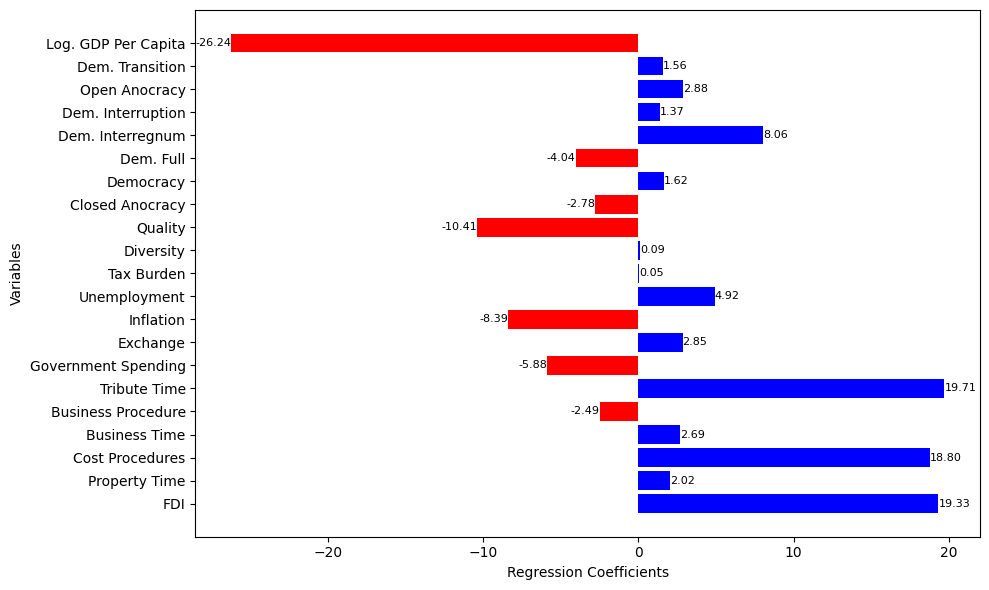

In [57]:
coeficientes = linear_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in coeficientes]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, coeficientes, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(coeficientes):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()

        
plt.show()

### Lasso

In [63]:
from sklearn.linear_model import Lasso

lasso_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'alpha': [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1.0, 10.0, 100.0],  
    'max_iter': [1000, 2000, 3000, 5000]  
}

# Create a lasso model
lasso_model = Lasso(random_state=0)

# Perform Grid Search with cross-validation
lasso_grid_search = GridSearchCV(lasso_model, 
                                  lasso_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=3,
                                  n_jobs=-1)

# Fitting the model
lasso_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", lasso_grid_search.best_params_)

# Get the best model
lasso_best_model = lasso_grid_search.best_estimator_

# Access cross-validation results
cv_results = lasso_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(lasso_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100  

    #print(f"nFold {fold_idx + 1}: Mean Score = {mean_score:.2f}%, Std = {std_score:.2f}%")

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = lasso_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

Fitting 5 folds for each of 128 candidates, totalling 640 fits

Best Parameters:  {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000}

Overall Mean Score on training set = 37.63%, Overall Std on training set= 19.14%

Mean Absolute Percentage Error (MAPE) on test set: 23.51% 



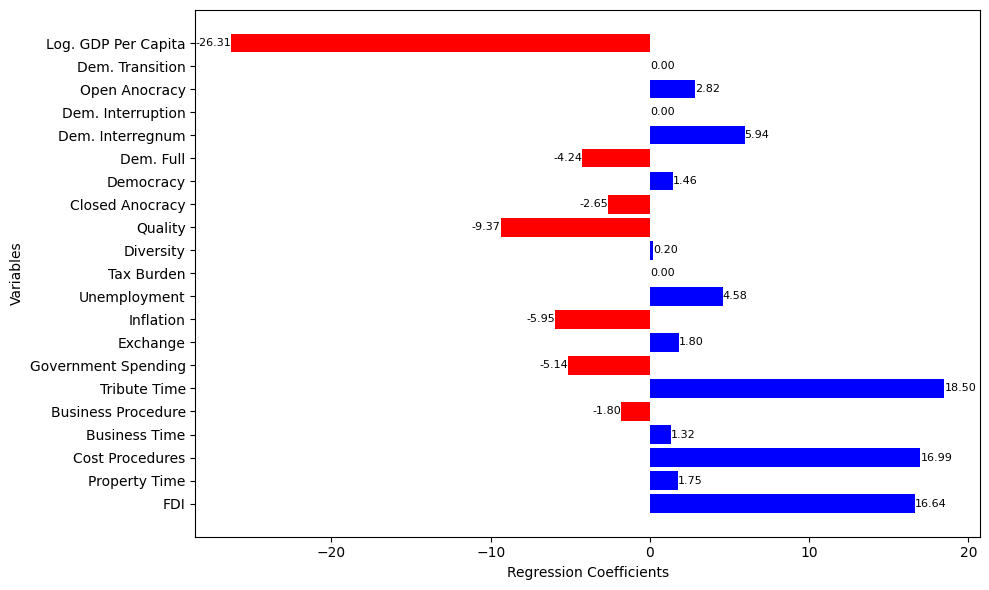

In [64]:
lasso_coeficients = lasso_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in lasso_coeficients]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, lasso_coeficients, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(lasso_coeficients):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()

        
plt.show()

### Ridge

In [66]:
from sklearn.linear_model import Ridge

ridge_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'alpha': [0.1, 0.5, 1.0, 1.5],  
    'max_iter': [1000, 2000, 3000]  
}

# Create a lasso model
ridge_model = Ridge(random_state=0)

# Perform Grid Search with cross-validation
ridge_grid_search = GridSearchCV(ridge_model, 
                                  ridge_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

# Fitting the model
ridge_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", ridge_grid_search.best_params_)

# Get the best model
ridge_best_model = ridge_grid_search.best_estimator_

# Access cross-validation results
cv_results = ridge_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(ridge_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100  

    #print(f"nFold {fold_idx + 1}: Mean Score = {mean_score:.2f}%, Std = {std_score:.2f}%")

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = ridge_best_model.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters:  {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000}

Overall Mean Score on training set = 26.56%, Overall Std on training set= 1.49%
Mean Absolute Percentage Error (MAPE) on test set: 23.45% 



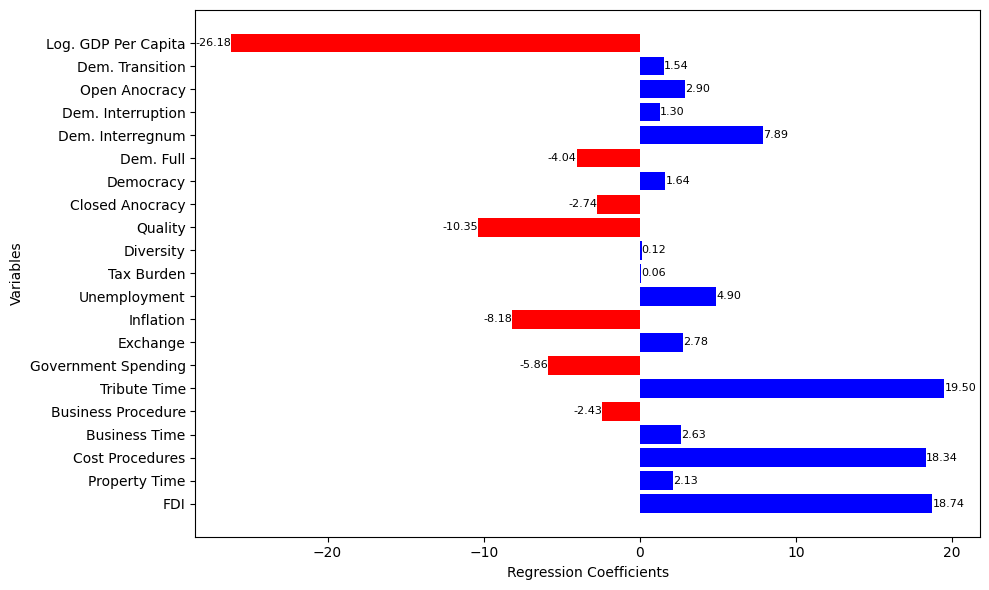

In [67]:
ridge_coeficients = ridge_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in ridge_coeficients]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, ridge_coeficients, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(ridge_coeficients):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()

        
plt.show()

### ElasticNet

In [68]:
from sklearn.linear_model import ElasticNet

en_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
              'l1_ratio': [0.25, 0.5, 0.75],
              'fit_intercept': [True, False],
              'max_iter': [1000, 2000, 3000],
              'tol': [1e-4, 1e-3, 1e-2]}

# Create a lasso model
en_model = ElasticNet(random_state=0)

# Perform Grid Search with cross-validation
en_grid_search = GridSearchCV(en_model, 
                                  en_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

# Fitting the model
en_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", en_grid_search.best_params_)

# Get the best model
en_best_model = en_grid_search.best_estimator_

# Access cross-validation results
cv_results = en_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(en_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100
    
# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = en_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

Fitting 5 folds for each of 270 candidates, totalling 1350 fits

Best Parameters:  {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.75, 'max_iter': 1000, 'tol': 0.01}

Overall Mean Score on training set = 38.85%, Overall Std on training set= 15.52%

Mean Absolute Percentage Error (MAPE) on test set: 23.44% 



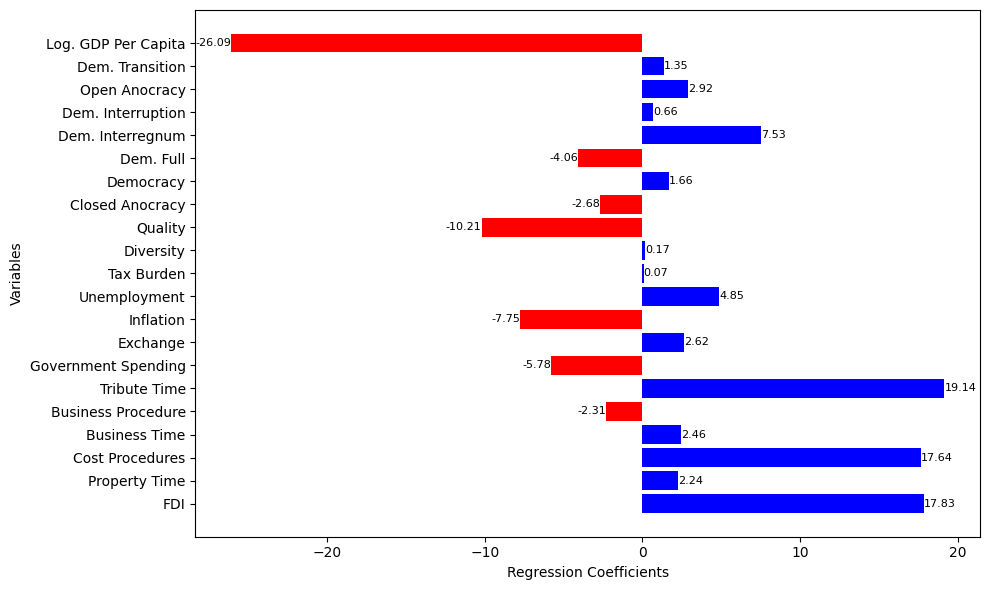

In [69]:
en_coeficients = en_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in en_coeficients]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, en_coeficients, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(en_coeficients):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()

        
plt.show()

### RandomForest

In [71]:
from sklearn.ensemble import RandomForestRegressor

rf_param_grid = {
    'n_estimators': [100, 200, 300],  
    'criterion': ['friedman_mse', 'squared_error', 'poisson', 'absolute_error'],  
    'max_depth': [None, 5, 10],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt'],  
    'bootstrap': [True, False]  
}

model_randomforest = RandomForestRegressor(random_state=0)

rf_grid_search = GridSearchCV(model_randomforest, 
                                  rf_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  n_jobs=-1)

# Fitting the model
rf_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", rf_grid_search.best_params_)

# Get the best model
rf_best_model = rf_grid_search.best_estimator_

# Access cross-validation results
cv_results = rf_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(rf_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100
    
    # Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = rf_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')


Best Parameters:  {'bootstrap': False, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Overall Mean Score on training set = nan%, Overall Std on training set= nan%

Mean Absolute Percentage Error (MAPE) on test set: 7.31% 



### SVR

In [72]:
from sklearn.svm import SVR

svr_param_grid = param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'C': [0.1, 1.0, 10.0],  
    'epsilon': [0.1, 0.2, 0.5]  
}

model_svr = SVR()

svr_grid_search = GridSearchCV(model_svr, 
                                  svr_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

svr_grid_search.fit(X_train_scaled, y_train)

# Get the best model
svr_best_model = svr_grid_search.best_estimator_

# Print the best parameters
print("\nBest Parameters: ", svr_grid_search.best_params_)

# Get the best model
svr_best_model = svr_grid_search.best_estimator_

# Access cross-validation results
cv_results = svr_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(svr_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100 
    
# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = svr_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters:  {'C': 10.0, 'epsilon': 0.1, 'kernel': 'poly'}

Overall Mean Score on training set = 31.38%, Overall Std on training set= 15.09%
Mean Absolute Percentage Error (MAPE) on test set: 15.69% 



In [73]:
explainer_sv = shap.Explainer(svr_best_model.predict, X_train)
shap_values_sv = explainer_sv(X_train)

Permutation explainer: 933it [13:12,  1.17it/s]                         


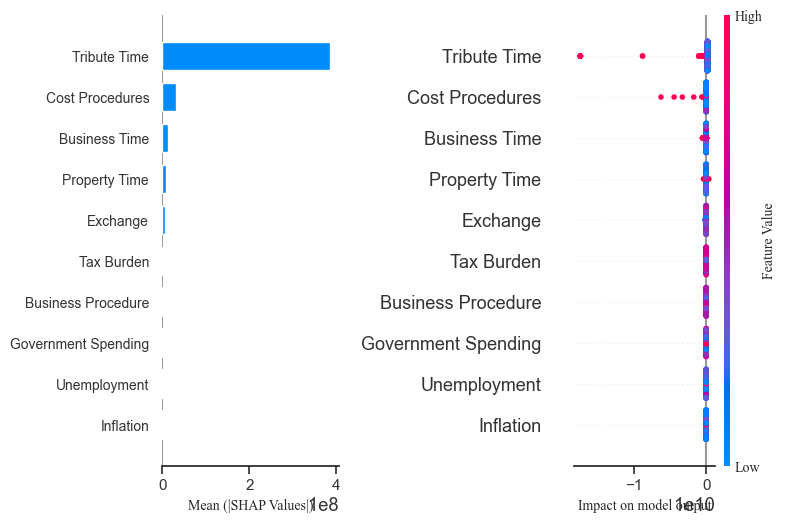

In [74]:
sns.set(style="white", font_scale=1.2)

# Aumentar o tamanho da figura
fig = plt.figure()
gs = GridSpec(1, 2, figure=fig)

f_1 = fig.add_subplot(gs[0])
shap.summary_plot(shap_values_sv, 
                  X_train, 
                  show=False,
                  max_display=10,
                 plot_type='bar')
# Alterar a fonte e os rótulos das variáveis no eixo y
plt.xlabel("Mean (|SHAP Values|)", fontname="Times New Roman", fontsize=10)
plt.tick_params(axis='y', labelsize=10)

f_2 = fig.add_subplot(gs[1])
shap.summary_plot(
    shap_values_sv, 
    X_train, 
    plot_type="dot",
    max_display=10, 
    auto_size_plot=False,
    show=False)
plt.xlabel("Impact on model output", fontname="Times New Roman", fontsize=10)

# Obter a colorbar atual
colorbar = plt.gcf().axes[-1]

# Alterar os rótulos da colorbar
colorbar.set_yticklabels(["Low", "High"], fontname="Times New Roman", fontsize=10)
colorbar.set_ylabel("Feature Value", fontname="Times New Roman", fontsize=10)

# Exibir a figura
plt.show()

### XGBoost

In [75]:
from xgboost import XGBRegressor

xgb_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  
    'max_depth': [3, 5, 10],  
    'n_estimators': [100, 200, 300],  
    'gamma': [0, 0.1, 0.2],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0]  
}

model_xgb = XGBRegressor()

xgb_grid_search = GridSearchCV(model_xgb, 
                                  xgb_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

xgb_grid_search.fit(X_train_scaled, y_train)

# Get the best model
xgb_best_model = xgb_grid_search.best_estimator_

# Print the best parameters
print("\nBest Parameters: ", xgb_grid_search.best_params_)

# Get the best model
xgb_best_model = xgb_grid_search.best_estimator_

# Access cross-validation results
cv_results = xgb_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(xgb_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100 

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = xgb_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Parameters:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}

Overall Mean Score on training set = 36.92%, Overall Std on training set= 31.40%
Mean Absolute Percentage Error (MAPE) on test set: 8.18% 



In [26]:
explainer_xgb = shap.Explainer(xgb_best_model)
shap_values_xgb = explainer_xgb(X_train)

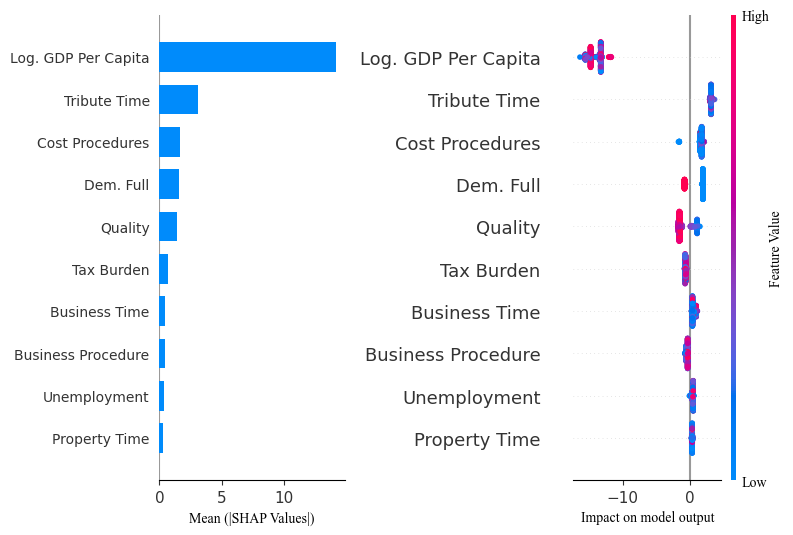

In [27]:
fig = plt.figure()
gs = GridSpec(1, 2, figure=fig)

f_1 = fig.add_subplot(gs[0])
shap.summary_plot(shap_values_xgb, 
                  X_train,
                  show=False,
                  max_display=10,
                 plot_type='bar')

plt.xlabel("Mean (|SHAP Values|)", fontname="Times New Roman", fontsize=10)
plt.tick_params(axis='y', labelsize=10)

f_2 = fig.add_subplot(gs[1])
shap.summary_plot(
    shap_values_xgb, 
    X_train,
    plot_type="dot",
    max_display=10, 
    auto_size_plot=False,
    show=False)
plt.xlabel("Impact on model output", fontname="Times New Roman", fontsize=10)

colorbar = plt.gcf().axes[-1]

colorbar.set_yticklabels(["Low", "High"], fontname="Times New Roman", fontsize=10)
colorbar.set_ylabel("Feature Value", fontname="Times New Roman", fontsize=10)

plt.show()

### LightGBM

In [76]:
from lightgbm import LGBMRegressor

lgb_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  
    'max_depth': [3, 5, 10],  
    'n_estimators': [100, 200, 300],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0]  
}

model_lgb = LGBMRegressor()

lgb_grid_search = GridSearchCV(model_lgb, 
                                  lgb_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

lgb_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", lgb_grid_search.best_params_)

# Get the best model
lgb_best_model = lgb_grid_search.best_estimator_

# Access cross-validation results
cv_results = lgb_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(lgb_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100  

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = lgb_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2866
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 18
[LightGBM] [Info] Start training from score 28.926513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [77]:
explainer_lgb = shap.Explainer(lgb_best_model)
shap_values_lgb = explainer_lgb(X_train)

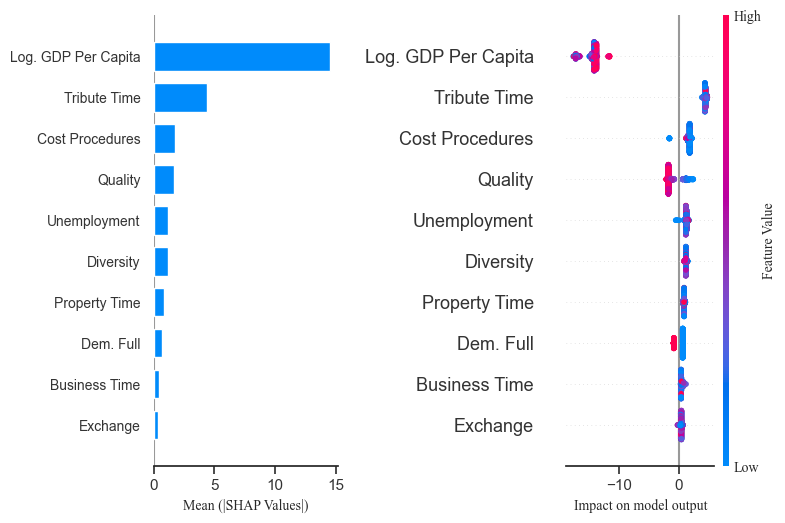

In [78]:
fig = plt.figure()
gs = GridSpec(1, 2, figure=fig)

f_1 = fig.add_subplot(gs[0])
shap.summary_plot(shap_values_lgb, 
                  X_train,
                  show=False,
                  max_display=10,
                 plot_type='bar')

plt.xlabel("Mean (|SHAP Values|)", fontname="Times New Roman", fontsize=10)
plt.tick_params(axis='y', labelsize=10)

f_2 = fig.add_subplot(gs[1])
shap.summary_plot(
    shap_values_lgb, 
    X_train,
    plot_type="dot",
    max_display=10, 
    auto_size_plot=False,
    show=False)
plt.xlabel("Impact on model output", fontname="Times New Roman", fontsize=10)

colorbar = plt.gcf().axes[-1]

colorbar.set_yticklabels(["Low", "High"], fontname="Times New Roman", fontsize=10)
colorbar.set_ylabel("Feature Value", fontname="Times New Roman", fontsize=10)

plt.show()

### CatBoost

In [79]:
from catboost import CatBoostRegressor

cb_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  
    'depth': [3, 5, 10],  
    'iterations': [100, 200, 300],  
}

model_cb = CatBoostRegressor()

cb_grid_search = GridSearchCV(model_cb, 
                                  cb_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

cb_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", cb_grid_search.best_params_)

# Get the best model
cb_best_model = cb_grid_search.best_estimator_

# Access cross-validation results
cv_results = cb_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(cb_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100

# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = cb_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 12.5134517	total: 182ms	remaining: 54.5s
1:	learn: 11.8873414	total: 233ms	remaining: 34.7s
2:	learn: 11.2396532	total: 286ms	remaining: 28.3s
3:	learn: 10.7109336	total: 337ms	remaining: 24.9s
4:	learn: 10.1510042	total: 390ms	remaining: 23s
5:	learn: 9.6273206	total: 451ms	remaining: 22.1s
6:	learn: 9.2364957	total: 505ms	remaining: 21.2s
7:	learn: 8.8171290	total: 560ms	remaining: 20.5s
8:	learn: 8.4325537	total: 611ms	remaining: 19.8s
9:	learn: 8.0422045	total: 662ms	remaining: 19.2s
10:	learn: 7.6518297	total: 715ms	remaining: 18.8s
11:	learn: 7.3226324	total: 771ms	remaining: 18.5s
12:	learn: 7.0143464	total: 823ms	remaining: 18.2s
13:	learn: 6.7136391	total: 872ms	remaining: 17.8s
14:	learn: 6.4797149	total: 931ms	remaining: 17.7s
15:	learn: 6.2207202	total: 980ms	remaining: 17.4s
16:	learn: 5.9778222	total: 1.03s	remaining: 17.1s
17:	learn: 5.7520947	total: 1.08s	remaining: 16.9s
18:	learn: 5.4967916	total:

In [80]:
explainer_cb = shap.Explainer(cb_best_model)
shap_values_cb = explainer_cb(X_train)

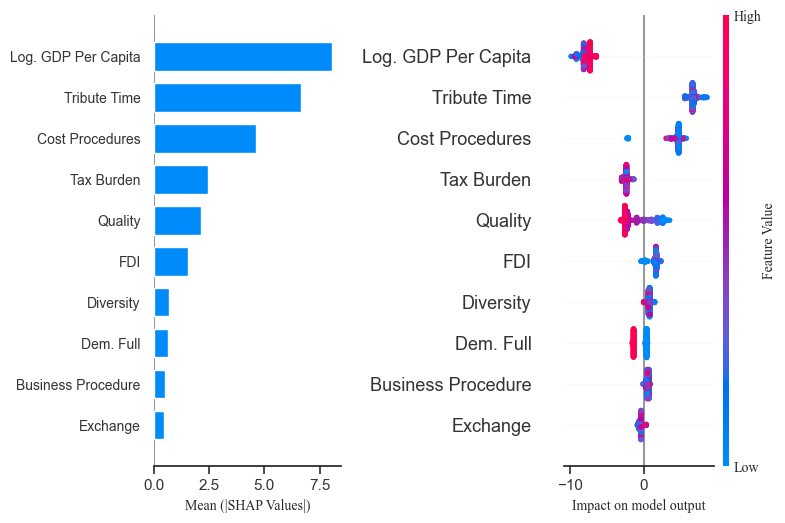

In [148]:
fig = plt.figure()
gs = GridSpec(1, 2, figure=fig)

f_1 = fig.add_subplot(gs[0])
shap.summary_plot(shap_values_cb, 
                  X_train,
                  show=False,
                  max_display=10,
                 plot_type='bar')

plt.xlabel("Mean (|SHAP Values|)", fontname="Times New Roman", fontsize=10)
plt.tick_params(axis='y', labelsize=10)

f_2 = fig.add_subplot(gs[1])
shap.summary_plot(
    shap_values_cb, 
    X_train,
    plot_type="dot",
    max_display=10, 
    auto_size_plot=False,
    show=False)
plt.xlabel("Impact on model output", fontname="Times New Roman", fontsize=10)

colorbar = plt.gcf().axes[-1]

colorbar.set_yticklabels(["Low", "High"], fontname="Times New Roman", fontsize=10)
colorbar.set_ylabel("Feature Value", fontname="Times New Roman", fontsize=10)

plt.show()

### Bagging

In [81]:
from sklearn.ensemble import BaggingRegressor

baggin_param_grid = {
    'n_estimators': [10, 50, 100],  
    'max_samples': [0.5, 0.7, 0.9],  
    'max_features': [0.5, 0.7, 0.9],  
}

model_bagging = BaggingRegressor()

bagging_grid_search = GridSearchCV(model_bagging, 
                                  baggin_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1)

bagging_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", bagging_grid_search.best_params_)

# Get the best model
bagging_best_model = bagging_grid_search.best_estimator_

# Access cross-validation results
cv_results = bagging_grid_search.cv_results_

# Print mean and std for each fold
for fold_idx in range(bagging_grid_search.cv):
    mean_score = -cv_results[f"split{fold_idx}_test_score"].mean() * 100  
    std_score = cv_results[f"split{fold_idx}_test_score"].std() * 100
    
# Calculate and print global mean and std
global_mean_score = -cv_results['mean_test_score'].mean() * 100  
global_std_score = cv_results['mean_test_score'].std() * 100  

print(f"\nOverall Mean Score on training set = {global_mean_score:.2f}%, Overall Std on training set= {global_std_score:.2f}%")

# Predictions and evaluations on test set
y_test_pred = bagging_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters:  {'max_features': 0.9, 'max_samples': 0.9, 'n_estimators': 100}

Overall Mean Score on training set = 11.59%, Overall Std on training set= 1.15%
Mean Absolute Percentage Error (MAPE) on test set: 9.77% 



In [82]:
explainer_bg = shap.Explainer(bagging_best_model.predict, X_train)
shap_values_bg = explainer_bg(X_train)

Permutation explainer: 933it [08:45,  1.74it/s]                         


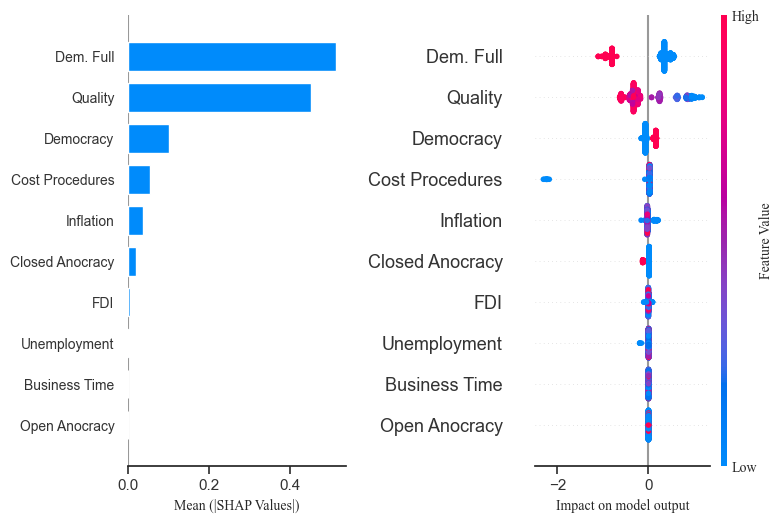

In [151]:
fig = plt.figure()
gs = GridSpec(1, 2, figure=fig)

f_1 = fig.add_subplot(gs[0])
shap.summary_plot(shap_values_bg, 
                  X_train,
                  show=False,
                  max_display=10,
                 plot_type='bar')

plt.xlabel("Mean (|SHAP Values|)", fontname="Times New Roman", fontsize=10)
plt.tick_params(axis='y', labelsize=10)

f_2 = fig.add_subplot(gs[1])
shap.summary_plot(
    shap_values_bg, 
    X_train,
    plot_type="dot",
    max_display=10, 
    auto_size_plot=False,
    show=False)
plt.xlabel("Impact on model output", fontname="Times New Roman", fontsize=10)

colorbar = plt.gcf().axes[-1]

colorbar.set_yticklabels(["Low", "High"], fontname="Times New Roman", fontsize=10)
colorbar.set_ylabel("Feature Value", fontname="Times New Roman", fontsize=10)

plt.show()